## Linear regression

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

path = 'C:/Users/Khristina/PycharmProjects/ML/datapoints.txt'
name = 'datapoints.txt'

# The input for n and lambda parameters is in the Model construction part of the code
# Data preparation 
with open(os.path.join(os.path.dirname(name), path), 'r') as file:
    data = file.read().replace('\n', ',').split(',')
    data = list(map(float, data))
X, y = np.matrix(data[::2]), np.matrix(data[1::2])
X, y = np.reshape(X, (X.shape[1], 1)), np.reshape(y, (y.shape[1], 1))

### Create design matrix A

In [2]:
def design_matrix(X, n):
    A = np.power(X, 0)
    for power in range(1, n):
        X_pow = np.power(X, power)
        A = np.column_stack((X_pow, A))
    return A

### Transpose matrix A

In [3]:
def transpose_matrix(A):
    A_transposed = np.matrix([[0 for x in range(A.shape[0])] for y in range(A.shape[1])], dtype=float)
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            A_transposed[j, i] = A[i, j]
    return A_transposed

### Matrix multiplication

In [4]:
def mul(B, C):
    A_mul = np.matrix(np.zeros((B.shape[0], C.shape[1])))
    for i in range(C.shape[1]):   # iterate throuhg columns of second
        for j in range(B.shape[0]):   # iterate through rows of the first
            for k in range(C.shape[0]):
                A_mul[j, i] += B[j, k]*C[k, i]
    return A_mul

### Identity

In [5]:
def identity_m(dim):
    I = np.matrix([[0 for x in range(dim)] for y in range(dim)])
    for i in range(dim):
        I[i, i] = 1
    return np.asarray(I)

### LU decomposition

In [6]:
def LU(A_dot):
    dim = A_dot.shape[0]
    # Create an empty LU coef matrix
    LU = np.matrix([[0 for x in range(dim)] for y in range(dim)], dtype='float')
    for k in range(dim):
        
        # Filling rows of LU composed matrix
        for j in range(k, dim):
            LU[k, j] = A_dot[k, j] - LU[k, :k]*LU[:k, j]
            
        # Filling columns of LU composed matrix
        for i in range(k + 1, dim):
            LU[i, k] = (A_dot[i, k] - LU[i, :k]*LU[:k, k])/LU[k, k]
    # Now we can make copies of our LU and fill in U with zeros and L also with 1 on its main diagonal
    U = LU.copy()
    L = LU.copy()
    for j in range(1, U.shape[0]):
        U[j, :j] = 0
    for i in range(L.shape[0]):
        L[i, i] = 1
        L[i, i+1:] = 0
    return L, U

In [7]:
# Solve an equation for L and U matricies
def SLAU(L, U, b):
    y = np.matrix(np.zeros([L.shape[0], 1]))
    for i in range(y.shape[0]):
        y[i, 0] = b[i] - L[i, :i]*y[:i] 

    x = np.matrix(np.zeros([U.shape[0], 1]))
    for i in range(1, x.shape[0]+1):
        x[-i, 0] = (y[-i] - U[-i, -i:]*x[-i:])/U[-i, -i]
    return x

In [8]:
def inv_m(A):
    a = A.copy()
    L, U = LU(a)
    Y = np.matrix(identity_m(L.shape[0]), dtype='float')
    inverse = []
    for col in Y:
        b = col.reshape((col.shape[1], 1))
        if len(inverse) == 0:   # add in inverse matrix rows of original matrix
            inverse = SLAU(L, U, b)
        else:
            inverse = np.column_stack((inverse, SLAU(L, U, b)))
    return inverse

### LSE

In [9]:
def linear_LSE(X, y, lmbd, n):
    A = design_matrix(X, n)
    A_tr = transpose_matrix(A)
    A_dot = mul(A_tr, A)   
    lmbd_I = lmbd*identity_m(len(A_dot))
    mtr_sum = A_dot + lmbd_I
    inv = inv_m(mtr_sum)
    w = mul(inv, mul(A_tr, y))  
    return w, A

## Newton's Method

In [10]:
def As(X, n):
    A = design_matrix(X, n)
    A_tr = transpose_matrix(A)
    A_dot = mul(A_tr, A)   
    return A, A_tr

In [11]:
def gradient(A, A_tr, X, b):
    first = 2*mul(mul(A_tr, A), X)  
    second = 2*mul(A_tr, b)   
    return first - second

In [12]:
def Hessian(A, A_tr):
    return inv_m(2*mul(A_tr, A))  

In [13]:
def Newton(X, y, n, w):
    A, A_tr = As(X, n)   # initial parameters     
    w = w - mul(Hessian(A, A_tr), gradient(A, A_tr, w, y))   # update predicted parameter 
    return w, A

### Error function

In [14]:
def l2_norm(A, y, w):
    error = 0
    for i in range(len(y)):
        f = sum(A[i]*w)
        error += (y[i] - f)**2
    return error

### Prediction

In [15]:
def predict(X, w):
    pred = np.asarray(sum(X[0]*w))
    for i in range(1, len(X)):
        pred = np.append(pred, sum(X[i]*w))
    return pred

# Models construction

LSE:
Fitting line: 0.8345332827002857x^2 + 0.09314819831918815x^1 + 0.04695069927346927
Total error: 22649.738493024153


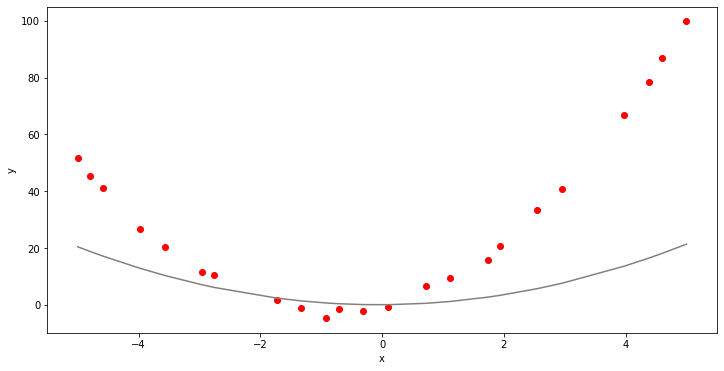

Newton's Method:
Fitting line: 3.0238533934865712x^2 + 4.906190263863799x^1 + -0.23140175608770586
Total error: 26.559959499333058


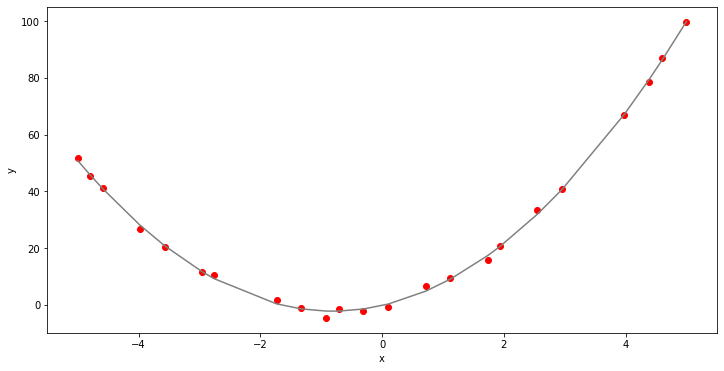

In [16]:
n = 3
lmbd = 10000

methods = ["LSE", "Newton's Method"]
for method in methods:
    if method == 'LSE':
        w, A = linear_LSE(X, y, lmbd, n)
    else:
        x = np.matrix(np.random.rand(n, 1))   # Create dummy w
        w, A = Newton(X, y, n, x)
    error = l2_norm(A, y, w)[0, 0]   # total error
    predictions = predict(A, w)
    
    # Create fitting line eq
    eq = ''
    for power, w1 in enumerate(np.flip(w)):
        if power == 0:
            eq = '{0}'.format(w1[0, 0])
        else:
            eq = '{1}x^{0} + {2}'.format(power, w1[0, 0], eq)
            
    print('{2}:\nFitting line: {0}\nTotal error: {1}'.format(eq, error, method))
    plt.figure(figsize=(12, 6))
    plt.plot(X, y, 'o', color='red')
    plt.plot(X, predictions, color = 'gray')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()